In [1]:
# Try the MLP Mixer applied to PNC data to regress ages
# arXiv:2105.01601v2 [cs.CV] 17 May 2021

# Bad subjects
# Bad IDs: 605515760919, 601983541597

# Load split

import pickle

badIDs = [605515760919, 601983541597]

with open('../../Splits/RegressionAllTasks/split1.bin', 'rb') as f:
    d = pickle.load(f)
    train = []
    trainDirty = d['train']
    test = []
    testDirty = d['test']
    
    # Remove bad subjects
    for subj in trainDirty:
        if subj['ID'] not in badIDs:
            train.append(subj)
            
    for subj in testDirty:
        if subj['ID'] not in badIDs:
            test.append(subj)
    
print(len(train))
print(len(test))
print(train[0])

466
156
{'meta': {'AgeInMonths': 146, 'Gender': 'F', 'Ethnicity': 'AFRICAN', 'AgeGroupID': 2, 'AgeGroupEdge1': 144, 'AgeGroupEdge2': 180}, 'rest': '30', 'nback': '31', 'emoid': '31', 'ID': 600262185931}


In [2]:
# Load data

def loadTimeseries(_id, _dir):
    ts = None
    with open('{:s}/{:d}.bin'.format(_dir, _id), 'rb') as f:
        ts = pickle.load(f)
    return ts

train_rest_ts = [loadTimeseries(int(subj['nback']), '../../nback_fmri_power264/timeseries') for subj in train]
# train_nback_ts = [loadTimeseries(int(subj['nback']), '../../nback_fmri_power264/timeseries') for subj in train]
# train_emoid_ts = [loadTimeseries(int(subj['emoid']), '../../emoid_fmri_power264/timeseries') for subj in train]

test_rest_ts = [loadTimeseries(int(subj['nback']), '../../nback_fmri_power264/timeseries') for subj in test]
# test_nback_ts = [loadTimeseries(int(subj['nback']), '../../nback_fmri_power264/timeseries') for subj in test]
# test_emoid_ts = [loadTimeseries(int(subj['emoid']), '../../emoid_fmri_power264/timeseries') for subj in test]

print('Complete')

Complete


In [3]:
# Normalize data

import numpy as np

def normalizeSubjects(subjects):
    for i in range(len(subjects)):
        subj = subjects[i]
        subj -= np.mean(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        subj /= np.std(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        if np.sum(np.isnan(subj)) > 0:
            print(i)
        if np.sum(np.isinf(subj)) > 0:
            print(i)

normalizeSubjects(train_rest_ts)
# normalizeSubjects(train_nback_ts)
# normalizeSubjects(train_emoid_ts)

normalizeSubjects(test_rest_ts)
# normalizeSubjects(test_nback_ts)
# normalizeSubjects(test_emoid_ts)

print('Complete')

Complete


In [4]:
# Create labels (ages)

y_train = np.vstack([subj['meta']['AgeInMonths'] for subj in train])
y_test = np.vstack([subj['meta']['AgeInMonths'] for subj in test])

print('Complete')

Complete


In [5]:
# Apply PCA

from sklearn.decomposition import PCA

pca = PCA(80)
pca.fit(np.vstack([subj.T for subj in train_rest_ts]))

train_rest_ts_pca = [pca.transform(subj.T).T for subj in train_rest_ts]
test_rest_ts_pca = [pca.transform(subj.T).T for subj in test_rest_ts]

print('Complete')

Complete


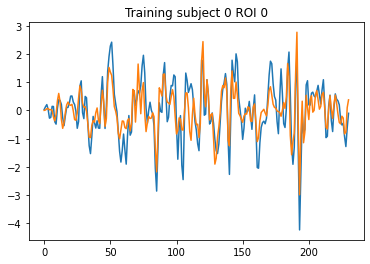

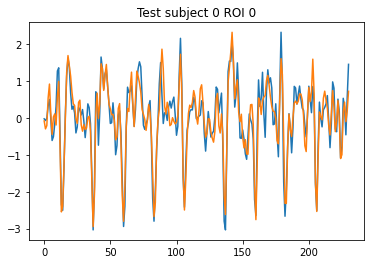

In [6]:
# Test PCA

import matplotlib.pyplot as plt

reconTrain = pca.inverse_transform(train_rest_ts_pca[0].T).T
reconTest = pca.inverse_transform(test_rest_ts_pca[0].T).T

plt.plot(train_rest_ts[0][0,:])
plt.plot(reconTrain[0,:])
plt.title('Training subject 0 ROI 0')
plt.show()

plt.plot(test_rest_ts[0][0,:])
plt.plot(reconTest[0,:])
plt.title('Test subject 0 ROI 0')
plt.show()

In [7]:
# Torch

import torch
import torch.nn as nn
import torch.nn.functional as F

cuda = torch.device('cuda')

train_rest_ts_torch = [torch.from_numpy(subj).T.float().cuda() for subj in train_rest_ts_pca]
test_rest_ts_torch = [torch.from_numpy(subj).T.float().cuda() for subj in test_rest_ts_pca]

# print(train_rest_ts_torch[0].device)
print('Complete')

Complete


In [47]:
# MLP Mixer
# Our data is already in the channels x patches format

nt = train_rest_ts_torch[0].shape[0]
nrois = 80
nLayers = 5

class MixerLayer():
    def __init__(self):
        self.dout1 = nn.Dropout(p=0.02)
        self.mlp1w = nn.Parameter(torch.randn(nt, nt, requires_grad=True).cuda()/nt/nt)
        self.mlp2w = nn.Parameter(torch.randn(nrois, nrois, requires_grad=True).cuda()/nrois/nrois)
        self.mlp1b = nn.Parameter(torch.randn(nt, requires_grad=True).cuda()/nt)
        self.mlp2b = nn.Parameter(torch.randn(nrois, requires_grad=True).cuda()/nrois)
    
    def forward(self, x):
        x = torch.einsum('abc,bd->abc', x, self.mlp1w)
        x += self.mlp1b.view(nt,1)
        x = torch.einsum('abc,cd->abc', x, self.mlp2w)
        x += self.mlp2b
        x = self.dout1(x)
        return x

class Mixer(nn.Module):
    def __init__(self):
        super(Mixer, self).__init__()
        self.mixerLayers = []
        self.mixerMlps = []
        for i in range(nLayers):
            self.mixerLayers.append(MixerLayer())
            self.mixerMlps.append(self.mixerLayers[-1].mlp1w)
            self.mixerMlps.append(self.mixerLayers[-1].mlp2w)
            self.mixerMlps.append(self.mixerLayers[-1].mlp1b)
            self.mixerMlps.append(self.mixerLayers[-1].mlp2b)
        self.mixerMlps = nn.ParameterList(self.mixerMlps)
        self.fc1 = nn.Linear(nrois*nt,20).cuda()
        self.fc2 = nn.Linear(20,1).cuda()
        self.dout = nn.Dropout(p=0.05)
        
    def forward(self, x):
        nb = x.shape[0]
        for layer in self.mixerLayers:
            x = layer.forward(x)
        x = x.reshape([nb,-1])
        x = self.dout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x
    
mixer = Mixer()
optim = torch.optim.Adam(mixer.parameters(), lr=1e-4)

print('Complete')

Complete


In [142]:
A = torch.ones(2,2)
B = torch.zeros(2,2, requires_grad=True)
optim = torch.optim.Adam([B], lr=1e-2)
C = torch.einsum('ab,ab->',A,B)
C.backward()
print(B.grad)
optim.step()
print(A)
print(B)

tensor([[1., 1.],
        [1., 1.]])
tensor([[1., 1.],
        [1., 1.]])
tensor([[-0.0100, -0.0100],
        [-0.0100, -0.0100]], requires_grad=True)


In [48]:
import random

N = len(train_rest_ts_torch)-1
running = 0
nEpoch = 3000
pPeriod = 50
nBatch = 10

for epoch in range(nEpoch):
    batch = []
    truth = torch.zeros(nBatch)
    for i in range(nBatch):
        idx = random.randint(0,N)
        subj = train_rest_ts_torch[idx]
        batch.append(subj.unsqueeze(0))
        truth[i] = y_train[idx,0]
    optim.zero_grad()
    pred = mixer(torch.cat(batch)).view(nBatch)
    loss = torch.sum((truth.cuda()-pred)**2)
    loss.backward()
    optim.step()
    running += loss
    if epoch % pPeriod == 0 or epoch == nEpoch-1:
        if epoch != 0:
            running = running/pPeriod
        print('epoch {:d} loss={:f}'.format(epoch, running))
        running = 0

print('Finished training')

epoch 0 loss=385657.750000
epoch 50 loss=336016.937500
epoch 100 loss=214932.609375
epoch 150 loss=20837.193359
epoch 200 loss=13424.836914
epoch 250 loss=9494.227539
epoch 300 loss=8449.913086
epoch 350 loss=7755.689941
epoch 400 loss=5583.417480
epoch 450 loss=5044.760254
epoch 500 loss=4937.608398
epoch 550 loss=5604.535645
epoch 600 loss=4165.208984
epoch 650 loss=3952.683594
epoch 700 loss=3692.147461
epoch 750 loss=4028.613281
epoch 800 loss=3341.158447
epoch 850 loss=3443.016113
epoch 900 loss=4074.443359
epoch 950 loss=3099.919678
epoch 1000 loss=3721.584229
epoch 1050 loss=3663.176758
epoch 1100 loss=3283.295166
epoch 1150 loss=3439.227539
epoch 1200 loss=3455.039551
epoch 1250 loss=3527.201904
epoch 1300 loss=3287.967041
epoch 1350 loss=2916.358398
epoch 1400 loss=3333.437012
epoch 1450 loss=3355.686279
epoch 1500 loss=2895.117676
epoch 1550 loss=3548.155518
epoch 1600 loss=3496.387451
epoch 1650 loss=3648.917480
epoch 1700 loss=3360.148438
epoch 1750 loss=3097.307129
epoch 1

In [41]:
print(mixer.mixerMlps[0].grad)

tensor([[ 3.5526,  3.5526,  3.5526,  ...,  3.5526,  3.5526,  3.5526],
        [ 0.0698,  0.0698,  0.0698,  ...,  0.0698,  0.0698,  0.0698],
        [ 1.7386,  1.7386,  1.7386,  ...,  1.7386,  1.7386,  1.7386],
        ...,
        [ 2.2118,  2.2118,  2.2118,  ...,  2.2118,  2.2118,  2.2118],
        [ 0.9996,  0.9996,  0.9996,  ...,  0.9996,  0.9996,  0.9996],
        [-0.1145, -0.1145, -0.1145,  ..., -0.1145, -0.1145, -0.1145]],
       device='cuda:0')


[[1.         0.91570257]
 [0.91570257 1.        ]]
1.4177630364969611
1.1268574355838978


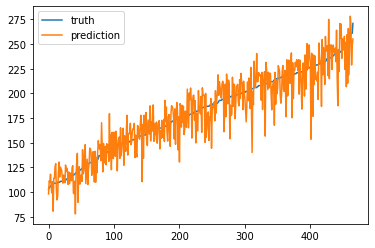

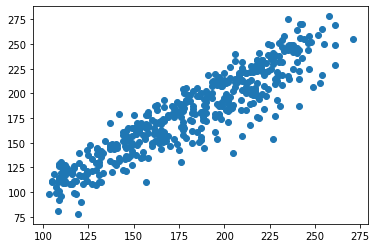

In [51]:
# Get predictions

y = y_train
X = train_rest_ts_torch
N = len(y)

pred = np.zeros(N)
y1 = np.zeros(N) # rmse
y2 = np.zeros(N) # mae
for i in range(N):
    pred[i] = mixer(X[i].unsqueeze(0)).cpu().detach()[0]
    y1[i] = (y[i,0]-pred[i])**2
    y2[i] = abs(y[i,0]-pred[i])
    
print(np.corrcoef(y.flatten(), pred))
print((y1.sum()/N)**0.5/12)
print(y2.sum()/N/12)
# print(y1)
# print(y2)

idcs = np.argsort(y,axis=0)
plt.plot(y[idcs,0], label='truth')
plt.plot(pred[idcs], label='prediction')
plt.legend()
plt.show()

plt.scatter(y.flatten(), pred)
plt.show()